In [1]:
# ROM for Building induced turbulence with coefficient parameterized for wind direction.
#Details of database
# Wind directions : E,S,W,NNE
#"2D plane mesh from 3D data"
# Polygonal Mesh - Cells : 433086 , Points : 234314
# k values range from 0 - 0.6 m2/s2.        

#Idea is to test : 1. POD + ACE on temporal coefficient + NeuralODE/LSTM on evolution.
#Idea2 is to test  2. ACE + LSTM/NeuralODE
#References of work.
 https://github.com/Romit-Maulik/CAE_LSTM_ROMS/blob/main/Burgers_Equations/AE_LSTM_MP.ipynb (look at this code for CAE)
CAE: https://github.com/Shady-Ahmed/NLPOD/blob/main/5_bae_param.py    (look at this code for CAE)
https://github.com/erdc/node_nirom  (look at this code for neural ode)
    # NeuralODE + CAE + LSTM :  https://github.com/CarlosJose126/NeuralODE-ROM/blob/main/VKS_lstm.py and

    #                           https://github.com/CarlosJose126/NeuralODE-ROM
https://github.com/surajp92/NIROM_SST/blob/main/example_noaa.py AND 
https://github.com/arvindmohan/LSTM_ROM_Arxiv/blob/master/analysis/ISO/BuildROMfromLSTM.ipynb

    # NeuralODE + CAE + LSTM :  https://github.com/CarlosJose126/NeuralODE-ROM/blob/main/VKS_lstm.py and

    #                           https://github.com/CarlosJose126/NeuralODE-ROM

    # ACE + LSTM :  https://github.com/Romit-Maulik/CAE_LSTM_ROMS/blob/main/Burgers_Equations/AE_LSTM_MP.ipynb

    #               and and https://github.com/Romit-Maulik/POD_LSTM_DayMet/blob/master/src/ML_Time.py 

 

######## Omer San's email to me to overcome Grassmann challenges  : "More recently, we have worked on the NLPOD and CAE ideas, please see attached paper. Either CAE or NLPOD can be used as an effective NIROM model. In CAE, there is no concept of basis functions, so there is no Grassmann manifold involved there. If we have data sets coming from 4 different Reynolds numbers, in the latent space, we can add (concatenate) one variable for Reynolds number and it will take care of the implementation automatically, once we test the new Reynolds number. In NLPOD, since it is based on POD basis function, so we may use Grassman manifold for new testing Reynolds number. Or we can store only one set of basis functions where data obtained from all Reynolds numbers, and use that set of the same basis functions for testing a new Reynolds number (which is somehow close or within the training set of Re) or in the same range that we collected. In the attached paper, we used that later approach (simple one without needing the Grassman)"  The relevant code can be seen here: https://github.com/Shady-Ahmed/NLPOD More specifically:
NLPOD: https://github.com/Shady-Ahmed/NLPOD/blob/main/4_baepod_param.py  CAE: https://github.com/Shady-Ahmed/NLPOD/blob/main/5_bae_param.py     https://blog.keras.io/building-autoencoders-in-keras.html

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import Rbf #for regression.




(4, 10)


4

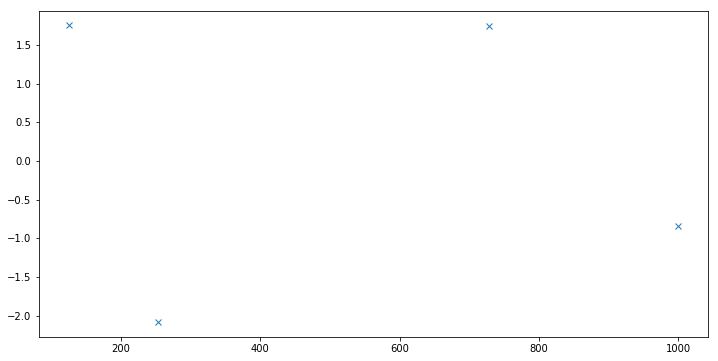

In [3]:
#Testing radial basis function based intepolation
# It will be used later for POD coefficients  to be function of wind direction
x=np.array([126, 254, 728, 999]) # num_downstream_planes
A=np.arange(40).reshape(4,-1) #
print(A.shape) #to test: num_downstream_planes x num_modes for current set-up


def func(x,y,z): return np.sin(x)+np.sin(y)+np.sin(z)
y=func(A[:,0],A[:,1],A[:,2])
plt.figure(figsize=(12,6))
ax=plt.plot(x,y,'x')
A[:,0].size


rbfi = Rbf(*A, func(A[:,0],A[:,1],A[:,2])) #replicating input A with column features, and output func as y.
xi = np.linspace(0, A[:,0].max(), 20)
yi = np.linspace(0, A[:,1].max(), 20)
zi = np.linspace(0, A[:,2].max(), 20)
di = rbfi(xi, yi, zi)   # test interpolant at new interpolated values
plt.plot(A[:,0],y,'xb',xi,di,'xg')

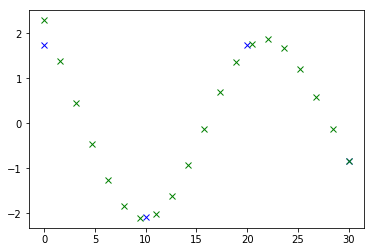

In [4]:
rbfi = Rbf(A[:,0],A[:,1],A[:,2], func(A[:,0],A[:,1],A[:,2])) #replicating input A with column features, and output func as y.
xi = np.linspace(0, A[:,0].max(), 20)
yi = np.linspace(0, A[:,1].max(), 20)
zi = np.linspace(0, A[:,2].max(), 20)
di = rbfi(xi, yi, zi)   # test interpolant at new interpolated values
plt.plot(A[:,0],y,'xb',xi,di,'xg')

In [5]:
#Filenames to load the data from U_surface1.vtk to U_surface8.vtk
fnyaw_0='/media/mandart/D/NorthWind-FME/Junmiao-database/270yaw/buildings'
#fnyaw_0='/media/mandart/D/NorthWind-FME/yaw_data/yaw0/558/'
#fnyaw_10='/media/mandart/D/NorthWind-FME/yaw_data/yaw10/558/'
#fnyaw_20='/media/mandart/D/NorthWind-FME/yaw_data/yaw20/surfaces/558/'

In [6]:
filenames=[fnyaw_0] #, fnyaw_10, fnyaw_20]

In [7]:
filenames[0]

'/media/mandart/D/NorthWind-FME/Junmiao-database/270yaw/buildings'

In [8]:
import pyvista
import pyvista as vtki
import numpy as np
import os
import pandas as pd
%config Completer.use_jedi = False



import vtk
from vtk.numpy_interface import dataset_adapter
from vtk.numpy_interface import algorithms as algs

import sys
from os.path import isdir, isfile, join
from os.path import expanduser
import numpy as np
import re

import json
import pickle
#To generate snapshots for basis functions - run the following script in paraview 
#%run run_in_paraview_for_snapshotdataset

/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: UserWarning: Config option `use_jedi` not recognized by `IPCompleter`.
  


In [9]:
import numpy as np
import random
import time as timer
import pickle

import matplotlib.pyplot as plt
import os, sys
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, concatenate
from tensorflow.keras.layers import LSTM, Flatten, Reshape, Conv2D, Conv2DTranspose, Dropout

from tensorflow.keras import backend as K
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [10]:
# https://stackoverflow.com/questions/59473267/why-in-keras-subclassing-api-the-call-method-is-never-called-and-as-an-alternat
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer#call
# the __call__ method is implemented in the Model class, so your subclass will inherit this method, which is why the call works. The __call__ in the parent Model class just forwards parameters to your subclass call method and does some bookkeeping.
# The input dimension is the last dimension in input shape to a layer.
# concate adds layers together. 
# tf.keras.layers.concatenate([x, y],                            axis=1) # Dimensions along other axis should be same.
## combine the output of the two branches : combined = concatenate([x.output, y.output]) # output gets added. Then use thos combined, z = Dense(2, activation="relu")(combined)


In [11]:
# VTK to python all files together

In [12]:
#Testing if we can load and manipulate variables
filename=fnyaw_20+"U_surface8.vtk"
grid_modes8 = pyvista.PolyData(filename)

filename=fnyaw_20+"U_surface1.vtk"
grid_modes1 = pyvista.PolyData(filename)

NameError: name 'fnyaw_20' is not defined

In [13]:
grid_modes1

NameError: name 'grid_modes1' is not defined

In [14]:
error=grid_modes1['U']-grid_modes8['U']

NameError: name 'grid_modes1' is not defined

In [15]:
error.min()/grid_modes1['U'].max()

NameError: name 'error' is not defined

In [16]:
error.shape

NameError: name 'error' is not defined

In [17]:
grid_modes8.point_data.set_vectors(error, "error")

NameError: name 'grid_modes8' is not defined

In [18]:
Utemp1=grid_modes8['U']

NameError: name 'grid_modes8' is not defined

In [19]:
vec=Utemp1.reshape(-1, 3, order='F')

NameError: name 'Utemp1' is not defined

In [20]:
#grid.cell_arrays
#grid_modes.cell_data["tke_mode_"+str(i)]=tbasis[:,i]
grid_modes8.point_data.set_vectors(vec, "velocity_mode") #["velocity_mode_"+str(i)]=sbasis[:,i] #Note cell data did not work. 

NameError: name 'grid_modes8' is not defined

In [21]:
vec.shape
grid_modes8.save('Test_surface2.vtk')

NameError: name 'vec' is not defined

In [22]:
# tips for uniform grid
# https://discourse.vtk.org/t/creating-uniform-rectilinear-slice-of-3d-data/1002/2

In [11]:
res=[]
for (root,dirs,files) in os.walk(fnyaw_0, topdown=True):
    for name in files:
        #print ((os.path.join(root, name)))
        #subs='U_zplane'
        #print(name)
        #break
        #res = [i for i in name if subs in os.path.join(root, name)]
        #print (root)
        #print (dirs)
        #print (files)
        #if name=='U_zplane.vtk':
        res.append(os.path.join(root, name))
            
       
        

In [12]:
res.sort()

In [13]:
res

['/media/mandart/D/NorthWind-FME/Junmiao-database/270yaw/buildings/E_7000_slice.vtk',
 '/media/mandart/D/NorthWind-FME/Junmiao-database/270yaw/buildings/NNE_7000_slice.vtk',
 '/media/mandart/D/NorthWind-FME/Junmiao-database/270yaw/buildings/N_3000_slice.vtk',
 '/media/mandart/D/NorthWind-FME/Junmiao-database/270yaw/buildings/SSW_7000_slide.vtk',
 '/media/mandart/D/NorthWind-FME/Junmiao-database/270yaw/buildings/S_7000_slice.vtk',
 '/media/mandart/D/NorthWind-FME/Junmiao-database/270yaw/buildings/W_3000_slice.vtk']

direc = sorted(next(os.walk(fnyaw_0))[2], key=lambda f: f) #0 for root name, 1 if subdirectories are present, 2 for files
# The next() function returns the next item in an iterator.
# 
direc1 = (next(os.walk(fnyaw_0,topdown=True))[1])


direc1

unwanted_num = {'U_surface_y.vtk', 'U_surface_z.vtk','p_surface_y.vtk','p_surface_z.vtk'}
direc = [ele for ele in direc if ele not in unwanted_num]


check = 'U'
Ufilename=[fn for fn in direc if fn[0].lower()=='U'.lower()]
# using list comprehension + lower()
# Words starting with specific letter
#res = [idx for idx in test_list if idx[0].lower() == check.lower()]

Ufilename

In [14]:
 def generate_data(res,charname='k'):       
        Ut11=[]
        for filename in res: 
            #loop on files - for testing [-2:][:2] filename1
            Utemp1=[]
        
            #filename=os.path.join(path, file)
            grid = vtki.PolyData(filename)
               
            print('creating TRAINING data for filename',filename)
            print(charname,type(charname),type('k'))
            Utemp1=grid[charname].ravel(order='F') #Flattened array 1D due to ravel
        
            Ut11.append(Utemp1)
    #LOOP OVER TIME STEP ENDS HERE. 
    # At the end of loop - We have a "list of arrays". The length of list= total number of arrays = "num_times", 
    # and each of these array is of size num_grid_size. 
    
    #CREATE 2D ARRAY FROM ABOVE LIST OF ARRAYS.
    #Below we use numpy stack, to combine list of arrays 
    #in such a way that each array in the list is added as new feature (as new column).
        print('lenUt11',len(Ut11))
        U1=np.stack(Ut11,axis=1)
        #it joins arrays from list of arrays.Dimensions along column a new axis.
        return U1,grid

In [21]:
k1,grid=generate_data(res,charname='k')

creating TRAINING data for filename /media/mandart/D/NorthWind-FME/Junmiao-database/270yaw/buildings/E_7000_slice.vtk
k <class 'str'> <class 'str'>
creating TRAINING data for filename /media/mandart/D/NorthWind-FME/Junmiao-database/270yaw/buildings/NNE_7000_slice.vtk
k <class 'str'> <class 'str'>
creating TRAINING data for filename /media/mandart/D/NorthWind-FME/Junmiao-database/270yaw/buildings/N_3000_slice.vtk
k <class 'str'> <class 'str'>
creating TRAINING data for filename /media/mandart/D/NorthWind-FME/Junmiao-database/270yaw/buildings/SSW_7000_slide.vtk
k <class 'str'> <class 'str'>
creating TRAINING data for filename /media/mandart/D/NorthWind-FME/Junmiao-database/270yaw/buildings/S_7000_slice.vtk
k <class 'str'> <class 'str'>
creating TRAINING data for filename /media/mandart/D/NorthWind-FME/Junmiao-database/270yaw/buildings/W_3000_slice.vtk
k <class 'str'> <class 'str'>
lenUt11 6


In [22]:
np.save('k_building_nigata.npy',k1)

U_reduced=U1[:,::6] #data sampled at 6*0.05 = 0.3 s.

In [ ]:
#Checking reducing the spaces.dd

np.save('U1reduced.npy',U_reduced)

In [23]:
k1.shape #num_spatial x num_times

(433086, 6)

In [24]:
k1.max()

0.653371

In [25]:
k1.min()

7.91944e-15

In [26]:
grid.array_names

['p', 'nut', 'k', 'omega', 'U', 'cellID', 'p', 'nut', 'k', 'omega', 'U']

In [27]:
type(grid)

pyvista.core.pointset.PolyData

In [162]:
grid.plot()

<bound method plot of PolyData (0x7ff0501f5dc8)
  N Cells:	433086
  N Points:	234314
  X Bounds:	-1.024e+00, 1.024e+00
  Y Bounds:	-1.024e+00, 1.024e+00
  Z Bounds:	1.000e-03, 1.000e-03
  N Arrays:	17
>

In [129]:
#POD functions

nd,ns = k1.shape
nr=np.min([10,ns])

def POD_svd(tdata,nr):
    
    nd,ns = tdata.shape #nd=grid, ns=wind direction (instead of time).
    
    
       
    #mean subtraction
    
    tm = np.mean(tdata) #tdata,axis=1, Use axis when 3D, and generating basis for each parameter.
    #um = np.mean(Au,axis=1)
    
    
    At = tdata - tm #.reshape([-1,1])
    
    
    print('At',At.shape)
    
    #singular value decomposition : https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html
    
    Ut, St, Vht = LA.svd(At, full_matrices=False)
    
   
    print(Ut.shape,St.shape,Vht.shape)
           
    Phit = Ut[:,:nr]  
    Lt = St**2
    
    #compute RIC (relative importance index)
    RICt = np.cumsum(Lt)/np.sum(Lt)*100
    
    
    return tm,Phit,Lt,RICt 

def PODproj_svd(u,Phi): #Projection
    a = np.dot(Phi.T,u)  # u = Phi * a if shape of a is [nr i.e num_modes,ns i.e num_winddirection]
    return a

def PODrec_svd(a,Phi): #Reconstruction    
    u = np.dot(Phi,a)    
    return u







###############################################################################
#POD Routines without mean
###############################################################################         
def POD(u,R): #Basis Construction
    n,ns = u.shape
    U,S,Vh = LA.svd(u, full_matrices=False)
    Phi = U[:,:R]
    L = S**2
    #compute RIC (relative inportance index)
    RIC = sum(L[:R])/sum(L)*100   
    
    return Phi,L,RIC

def PODproj(u,Phi): #Projection
    a = np.dot(u.T,Phi)  # u = Phi * a.T
    return a

def PODrec(a,Phi): #Reconstruction    
    u = np.dot(Phi,a.T)    
    return u


In [130]:
import numpy.linalg as LA

In [131]:
#Obtain POD basis functions for turbulent kinetic energy

In [42]:
tm,Phit,Lt,RICt=POD_svd(k1,nr) #mean tke, tke basis functions (modes) , magnitude (energy) , relative importance of modes. 

At (433086, 6)
(433086, 6) (6,) (6, 6)


In [ ]:
k1_wo_mean = k1-tm

tcoeff = PODproj_svd(k1_wo_mean,Phit)

In [43]:
tm

0.10376703

In [44]:
# create plots folder
fn="./Plots1"
if os.path.isdir(fn):
    print('Plots folder already exists')
else: 
    print('Creating plots folder')
    os.makedirs(fn)

Plots folder already exists


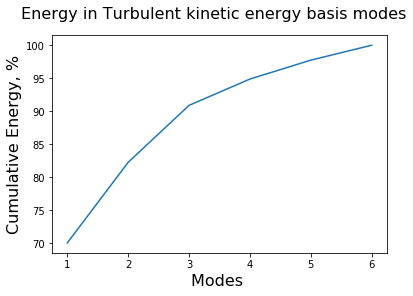

In [141]:
fig = plt.figure()
plt.plot(range(1,nr+1),np.cumsum(Lt)/sum(Lt)*100)
fig.suptitle('Energy in Turbulent kinetic energy basis modes', fontsize=16)
plt.xlabel('Modes ', fontsize=16)
plt.ylabel('Cumulative Energy, %', fontsize=16)
fig.savefig(fn+'/Cumulative_Energy_Velocity.png')
fig.savefig(fn+'/Cumulative_Energy_Velocity.pdf')

In [132]:
for i in range(nr): #nr , first 5 modes saved.
    grid.cell_data["tke_mode_"+str(i)]=Phit[:,i]
    

/home/mandart/.local/lib/python3.6/site-packages/pyvista/jupyter/notebook.py:60: UserWarning: Failed to use notebook backend: 

Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(f'Failed to use notebook backend: \n\n{e}\n\n'


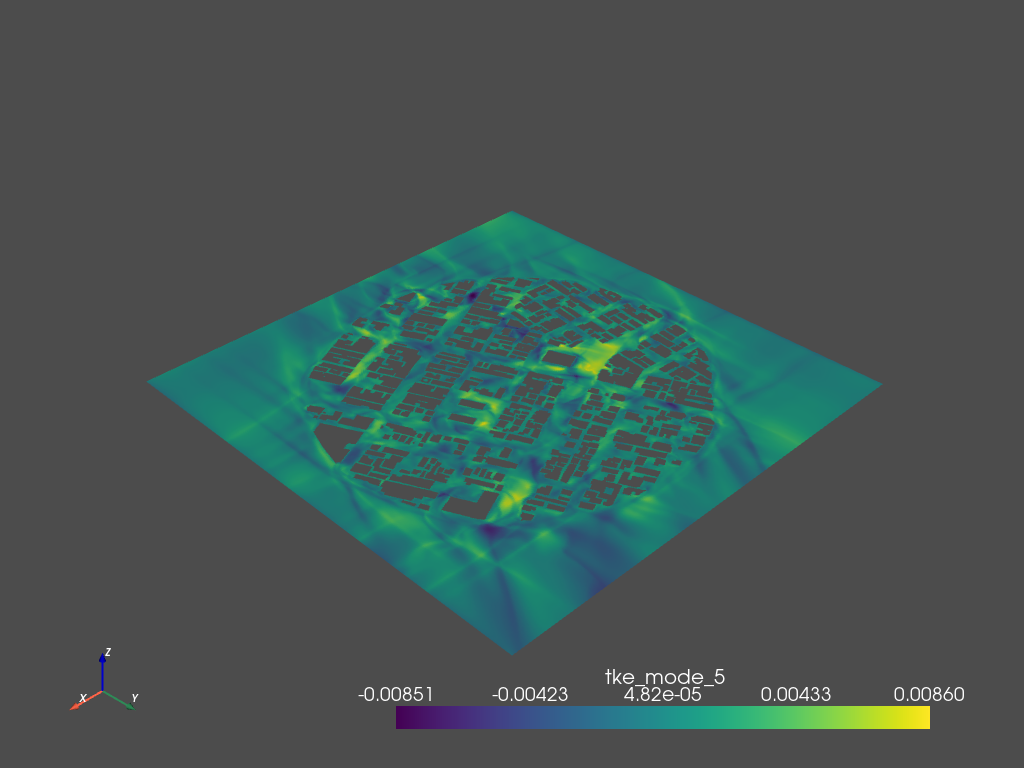

In [153]:
#fig, axs=plt.subplots(6)
grid.plot(["tke_mode_3"])

In [133]:
#Important basis modes saved in new VTK files
grid.save('Basisadded.vtk')

In [47]:
nr,ns

(6, 6)

In [155]:
#%% Save data
folder = 'data_POD' #str(nx) + '_' + str(ny)       
if not os.path.exists('./Results/'+folder):
    os.makedirs('./Results/'+folder)

filename = './Results/'+folder+'/POD_data.npz'
np.savez(filename, tmean=tm, tbasis=Phit,tcoeff=tcoeff,teigenvalues=Lt,tric=RICt)
    

folder = 'data_POD'
filename = './Results/'+folder+'/POD_data.npz'
#### A NpzFile object is returned. This is a dictionary-like object that 
#### can be queried for its list of arrays (with the .files attribute), 
### and for the arrays themselves.
PODdata=np.load(filename)

type(PODdata) #list of all variables as string

#loading from npz file - all keys as variables.
locals().update(PODdata) 
# In the Ipython session, locals() is a large dictionary with variables the you've defined,
# the input history lines, and various outputs. update adds the dictionary values of npzfile 
# to that larger one. for item in PODdata.files:
#print(item,type(item))
 #   item=PODdata[item]


In [156]:
Phit.shape

(433086, 6)

In [157]:
tcoeff.shape

(6, 6)

In [64]:
input_feature=[90,22.5,360,200,180,270] #[E,NNE,N,SSW,S,W]

In [65]:
#Convert cyclic input feature into form required 

In [66]:
input_feature

[90, 22.5, 360, 200, 180, 270]

deg_to_rad=np.array(input_feature)*np.pi/180

np.radians(np.array(input_feature))

deg_to_rad

In [ ]:
#2*pi*radius is the circumference of the circle. 
# (Whole range of variable/max of variable) is assumed to be represented by 2*pi.
#(min_value_variable/max of variable) is represented by 2*pi.
#obtain two values from it - np.sin and np.cosine.


max_deg_to_rad=360*np.pi/180 #i.e 2*pi
xsin = np.sin(2 * np.pi * deg_to_rad/max_deg_to_rad)
xcos= np.cos(2 * np.pi * deg_to_rad/max_deg_to_rad)
plt.plot(xsin,xcos,'x')
plt.plot(np.sin(2 * np.pi *(0.5/360)),np.cos(2 * np.pi *0.5/360),'o',label='0.5')
plt.plot(np.sin(2 * np.pi *(355/360)),np.cos(2 * np.pi *355/360),'o',label='355')
plt.plot(np.sin(2 * np.pi *(180/360)),np.cos(2 * np.pi *180/360),'o',label='180')
#plt.plot(np.sin(2 * np.pi *(180*np.pi/180)/360),np.cos(2 * np.pi *(180*np.pi/180)/360),'o')
plt.legend()

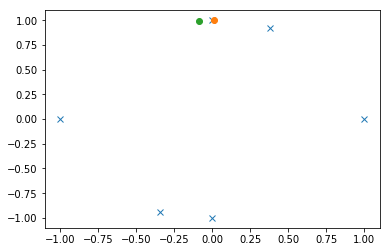

In [94]:
data=np.array(input_feature)
max_value=360
xsin1=np.sin(2 * np.pi * data / max_value)
xcos1=np.cos(2 * np.pi * data / max_value)
plt.plot(xsin1,xcos1,'x')
plt.plot(np.sin(2 * np.pi *(0.5/360)),np.cos(2 * np.pi *0.5/360),'o',label='0.5')
plt.plot(np.sin(2 * np.pi *(355/360)),np.cos(2 * np.pi *355/360),'o',label='355')
    

In [55]:
res

['/media/mandart/D/NorthWind-FME/Junmiao-database/270yaw/buildings/E_7000_slice.vtk',
 '/media/mandart/D/NorthWind-FME/Junmiao-database/270yaw/buildings/NNE_7000_slice.vtk',
 '/media/mandart/D/NorthWind-FME/Junmiao-database/270yaw/buildings/N_3000_slice.vtk',
 '/media/mandart/D/NorthWind-FME/Junmiao-database/270yaw/buildings/SSW_7000_slide.vtk',
 '/media/mandart/D/NorthWind-FME/Junmiao-database/270yaw/buildings/S_7000_slice.vtk',
 '/media/mandart/D/NorthWind-FME/Junmiao-database/270yaw/buildings/W_3000_slice.vtk']

North (N): 0° = 360°
East (E): 90°
South (S): 180°
West (W): 270°
Intercardinal directions
The intercardinal (intermediate, or, historically, ordinal[2]) directions are the four intermediate compass directions located halfway between each pair of cardinal directions.

Northeast (NE), 45°, halfway between north and east, is the opposite of southwest.
Southeast (SE), 135°, halfway between south and east, is the opposite of northwest.
Southwest (SW), 225°, halfway between south and west, is the opposite of northeast.
Northwest (NW), 315°, halfway between north and west, is the opposite of southeast.


In [180]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

plt.rc('font', **font)

/usr/lib/python3/dist-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


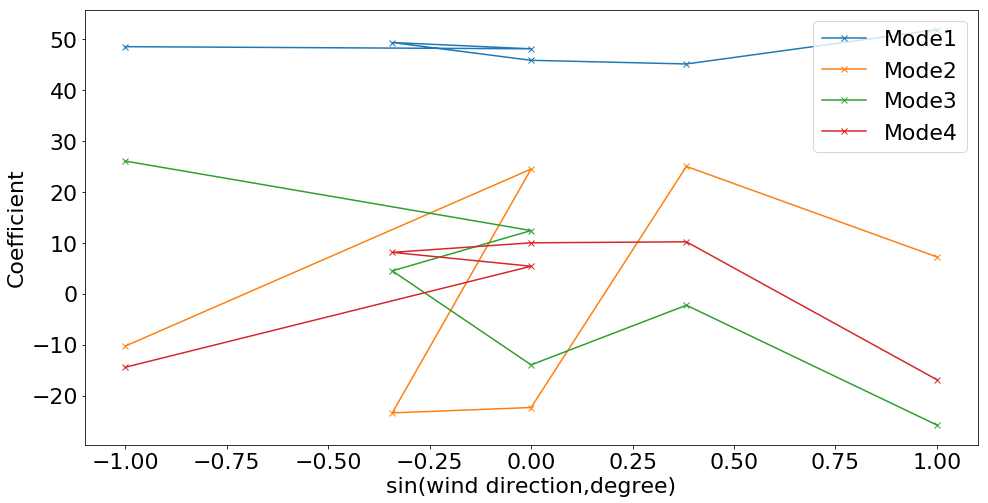

In [182]:
#tcoeff #modes x wind_direction
plt.figure(figsize=(16,8))
for i in range(4): #6
    plt.plot(xsin1,tcoeff[i,:],'x-',label='Mode'+str(i+1))
plt.xlabel('sin(wind direction,degree)')
plt.ylabel('Coefficient')
plt.legend()   

/usr/lib/python3/dist-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


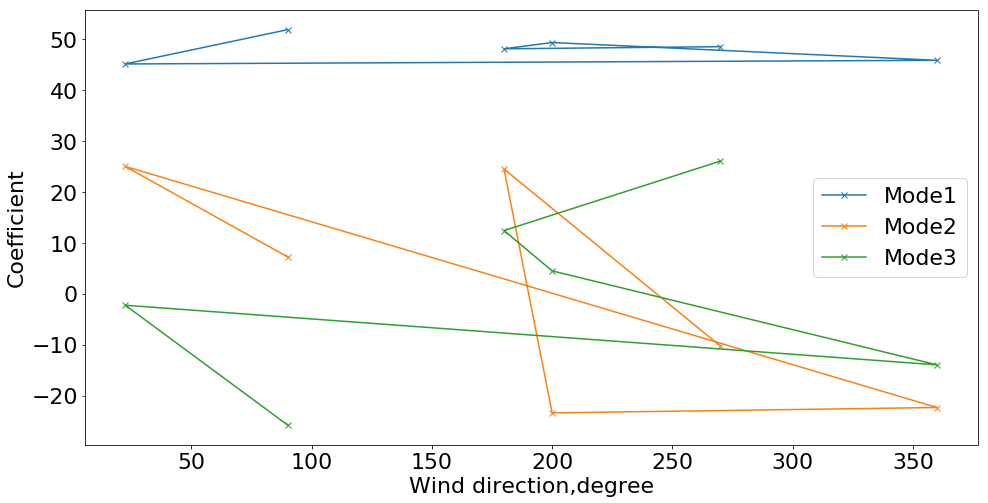

In [184]:
#tcoeff #modes x wind_direction
plt.figure(figsize=(16,8))
for i in range(3): #6
    plt.plot(data,tcoeff[i,:],'x-',label='Mode'+str(i+1))
plt.xlabel('Wind direction,degree')
plt.ylabel('Coefficient')
plt.legend()  
plt.savefig('./Results/coeff_vs_wd.png')
plt.savefig('./Results/coeff_vs_wd.pdf')

In [114]:
nr

6

# Create nr Rbf interpolator model for each nr Coefficient as a function of wind direction. 

In [167]:
import numpy as np
from scipy.interpolate import Rbf
import pickle


# Create Rbf interpolators for each mode. Then 
interpolators = []
for i in range(nr):
    rbf = Rbf(xsin1,xcos1,tcoeff[i,:],function='multiquadric') 
    interpolators.append(rbf)

# Save the Rbf interpolators to a file
with open('./Results/'+'rbf_interpolators.pkl', 'wb') as file:
    pickle.dump(interpolators, file)

# Load the Rbf interpolators from a file
with open('./Results/'+'rbf_interpolators.pkl', 'rb') as file:
    loaded_interpolators = pickle.load(file)

# Interpolate using the loaded interpolators (for demonstration)

predicted_values = []
for i, rbf in enumerate(loaded_interpolators):
    predicted_values.append(rbf(xsin1,xcos1))

# The 'predicted_values' list now contains the interpolated values using the loaded interpolators.


In [164]:
PODdata.files

['tmean', 'tbasis', 'tcoeff', 'teigenvalues', 'tric']

np.array(predicted_values)

# Plot temporal coefficients : check RBF interpolation

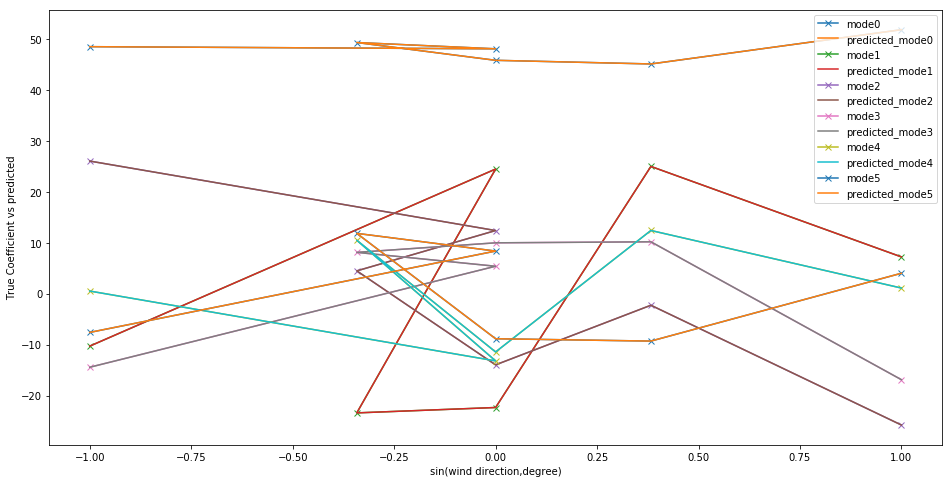

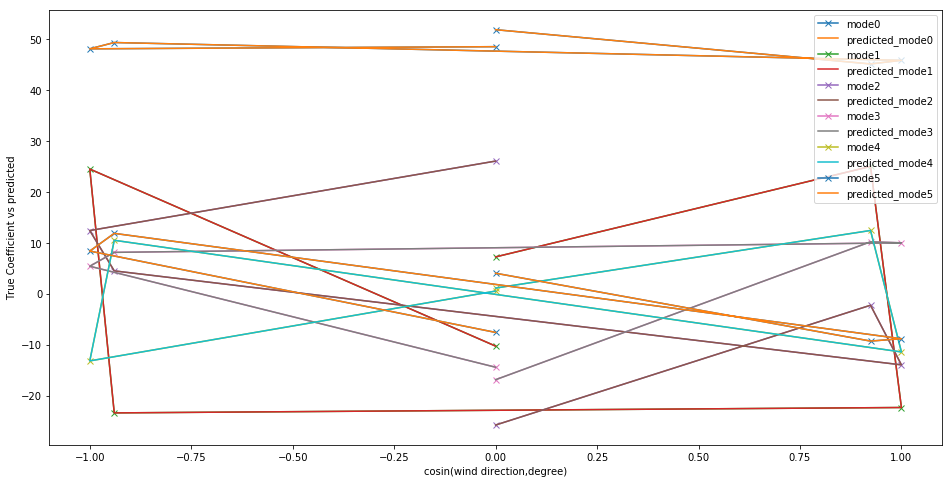

In [160]:
plt.figure(figsize=(16,8))
for i in range(6):
    plt.plot(xsin1,tcoeff[i,:],'x-',label='mode'+str(i))
    plt.plot(xsin1,np.array(predicted_values)[i,:],label='predicted_mode'+str(i))
plt.xlabel('sin(wind direction,degree)')
plt.ylabel('True Coefficient vs predicted')
plt.legend()

plt.figure(figsize=(16,8))
for i in range(6):
    plt.plot(xcos1,tcoeff[i,:],'x-',label='mode'+str(i))
    plt.plot(xcos1,np.array(predicted_values)[i,:],label='predicted_mode'+str(i))
plt.xlabel('cosin(wind direction,degree)')
plt.ylabel('True Coefficient vs predicted')
plt.legend()

# Reconstruct flow field for a given wind direction

In [217]:
import time
start = time.process_time()
# your code here    

# Assume a wind direction 
wind_dir=322 #in degrees


#Obtain coefficient for this wind direction
#------------------------------------------------------------------

#Load interpolators
with open('./Results/'+'rbf_interpolators.pkl', 'rb') as file:
    loaded_interpolators = pickle.load(file)

    
# Interpolate using the loaded interpolators (for demonstration)
predicted_coef = []
max_value=360
xsin_winddir=np.sin(2 * np.pi * wind_dir / max_value)
xcos_winddir=np.cos(2 * np.pi * wind_dir / max_value)
for i, rbf1 in enumerate(loaded_interpolators):
    predicted_coef.append(rbf1(xsin_winddir,xcos_winddir))
    print('Coeff for mode', i+1 , 'is ', rbf1(xsin_winddir,xcos_winddir))

#Obtain basis functions
#----------------------------------------------------------------------------------------------------

#Load saved basis functions (modes) and mean turbulent kinetic energy
filename = './Results/'+folder+'/POD_data.npz' #A NpzFile is a dictionary-like object.Query with the .files attribute) and for the arrays themselves.
folder = 'data_POD'
PODdata=np.load(filename)
Phit=PODdata['tbasis']
tke_mean=PODdata['tmean']


#Reconstruct flow field from the basis modes, the mean and the computed coefficients
#----------------------------------------------------------------------------------------------------
tke_at_wind_direction=np.dot(Phit,np.array(predicted_coef))+tke_mean

#Visualize reconstructed flow field.
#----------------------------------------------------------------------------------------------------
grid.cell_data["RECON_tke_at_WD_"+str(wind_dir)]=tke_at_wind_direction


#Print time taken
print(time.process_time() - start)

Coeff for mode 1 is  47.73753339054471
Coeff for mode 2 is  -43.018214080473044
Coeff for mode 3 is  -5.768148787020962
Coeff for mode 4 is  -2.9722836003754187
Coeff for mode 5 is  -26.96004071680072
Coeff for mode 6 is  -9.885270737024092
0.3244367459999751


In [218]:
grid.save('./Results/recon_added.vtk')

loaded_interpolators 

PODdata.files

In [186]:
np.array(predicted_coef).shape

(6, 6)

In [207]:
tke_at_wind_direction.shape

(433086,)

di = rbfi(test_featur[0])   # test interpolant at new interpolated values
plt.plot(input_feature,scoeff[0,0,include],'xb',test_featur[0],di,'xg')

# plot figures 